## MOEA/D_FPA


This algorithm is implemented based on <cite data-cite="moead"></cite>. The algorithm is based on [Reference Directions](../misc/reference_directions.ipynb) which need to be provided when initializing the algorithm object.

12.190421342849731


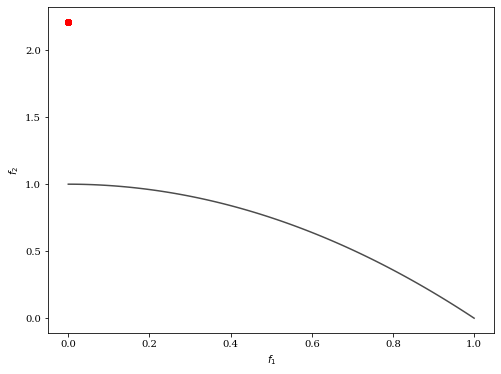

In [198]:
from pymoo.algorithms.moead_fpa import MOEAD_FPA
from pymoo.factory import get_problem, get_visualization, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.decomposition.perp_dist import PerpendicularDistance

problem = get_problem("zdt2")
n_obj = 2
algorithm = MOEAD_FPA(decomposition=Tchebicheff(), n_neighbours=20)
res = minimize(problem, algorithm, termination=('n_gen', 200))
print(res.exec_time)
if n_obj == 2:
    plot = Scatter()
    plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
    plot.add(res.F, color="red")
    plot.show()
else:
    plot = Scatter().add(res.F)
    plot.show()
# print(res.opt.get("F"))
    


### API